# Ultimate Challenge - Login EDA

### Imports & data

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### Aggregate logins into 15-min intervals

In [3]:
logins['logins'] = 1
logins_15m_int = logins.set_index('login_time').resample('15min').count()
logins_15m_int['avg'] = logins_15m_int.logins.mean()
logins_15m_int.head()

,logins,avg
login_time,,
1970-01-01 20:00:00,2,9.515938
1970-01-01 20:15:00,6,9.515938
1970-01-01 20:30:00,9,9.515938
1970-01-01 20:45:00,7,9.515938
1970-01-01 21:00:00,1,9.515938


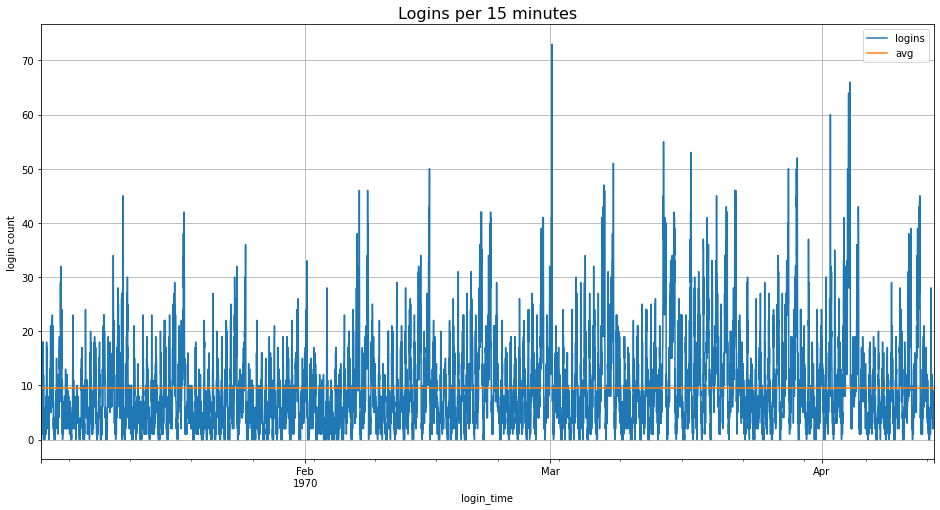

In [4]:
logins_15m_int.plot(figsize=(16, 8), grid=True)
plt.title('Logins per 15 minutes', fontsize=16)
plt.ylabel('login count');

##### - Every 15 minutes, there are between 9 and 10 logins on average
##### - For the most part, the number of logins appears to oscillate below 30 logins (within 15-minute intervals)
##### - The highest number of logins in any 15-minute interval is a little over 70 logins

### Average interval counts by day

In [5]:
logins_15m_int['time'] = logins_15m_int.index.time
logins_15m_int.head()

,logins,avg,time
login_time,,,
1970-01-01 20:00:00,2,9.515938,20:00:00
1970-01-01 20:15:00,6,9.515938,20:15:00
1970-01-01 20:30:00,9,9.515938,20:30:00
1970-01-01 20:45:00,7,9.515938,20:45:00
1970-01-01 21:00:00,1,9.515938,21:00:00


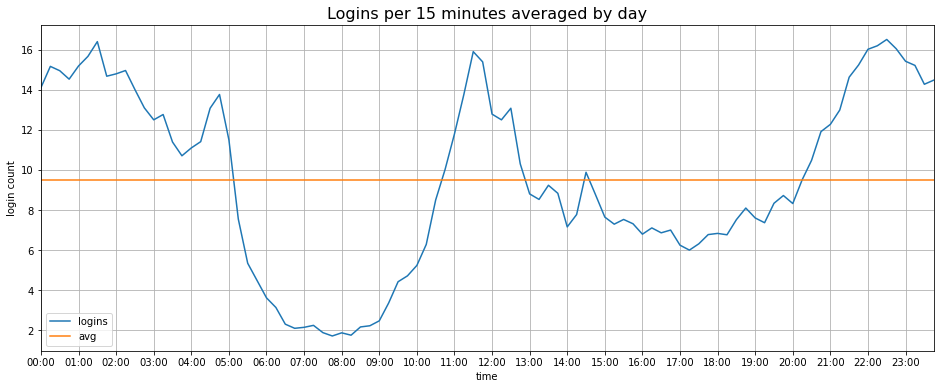

In [6]:
idx = pd.date_range('00:00', '23:00', freq='h').time
logins_15m_int.groupby('time').mean().plot(figsize=(16, 6), grid=True, xticks=idx, xlim=(datetime.time(0, 0), datetime.time(23, 45)))
plt.title('Logins per 15 minutes averaged by day', fontsize=16)
plt.ylabel('login count');

##### - Logins peak at around 1:30 AM, 11:30 AM, and 10:30 PM
##### - At 5 AM, the number logins drops dramatically, bottoming out around 8 AM, before increasing again to peak out at noon
##### - Logins dip below the average again between 1 PM and 8 PM
##### - Usage is the highest at noon and in the late night hours (between 9 PM and 5 AM) so efforts should be focused here
##### - There is very little usage between the hours of 6 AM and 10 AM

### Group daily average by weekday

In [7]:
logins_15m_int['weekday'] = logins_15m_int.index.weekday
logins_by_weekday = logins_15m_int.groupby(['weekday', 'time']).mean()
logins_by_weekday.head()

logins       avg
weekday time                        
0       00:00:00  8.400000  9.515938
        00:15:00  9.333333  9.515938
        00:30:00  9.600000  9.515938
        00:45:00  8.066667  9.515938
        01:00:00  7.266667  9.515938

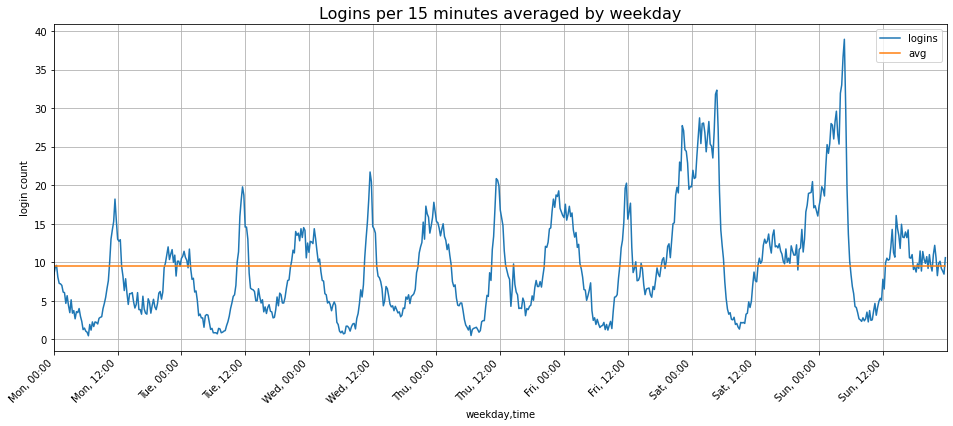

In [8]:
# Labels for xticks
ticks = range(0, logins_by_weekday.shape[0], 48)
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
labels = [f'{weekdays[i//2]}, 12:00' if i % 2 else f'{weekdays[i//2]}, 00:00' for i in range(14)]

logins_by_weekday.plot(figsize=(16, 6), grid=True, xlim=(0, logins_by_weekday.shape[0]))
plt.title('Logins per 15 minutes averaged by weekday', fontsize=16)
plt.ylabel('login count')
plt.xticks(ticks, labels, rotation=45, ha='right');

##### - The general pattern of peaking at noon and late night continues throughout the week
##### - Late night usage increases day by day, starting on Monday and maxing out on the weekends
##### - Logins during times of low usage remain relatively constant throughout the weekdays and has a small increase in the weekends
##### - Efforts should be focused on the weekends, especially during late night hours

### Aggregate logins to daily intervals

In [9]:
logins_15m_int['dayofyear'] = logins_15m_int.index.dayofyear
logins_daily = logins_15m_int.groupby('dayofyear')[['logins']].sum()
logins_daily['avg_daily'] = logins_daily.logins.mean()
logins_daily.head()

,logins,avg_daily
dayofyear,,
1,112,904.291262
2,681,904.291262
3,793,904.291262
4,788,904.291262
5,459,904.291262


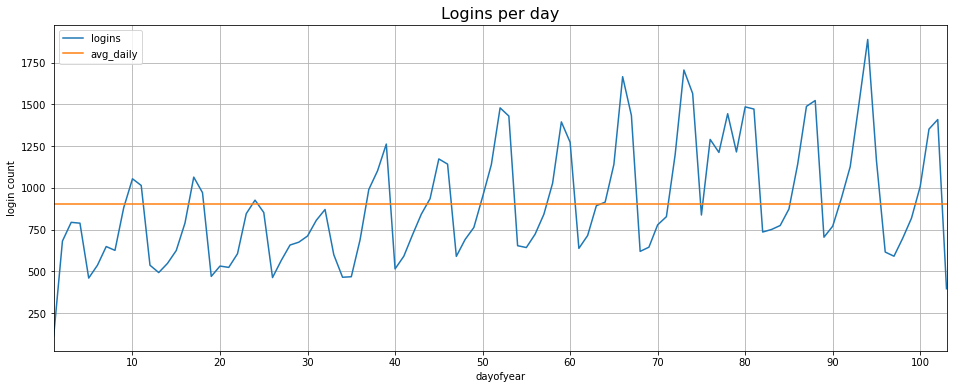

In [10]:
last_day = logins_15m_int['dayofyear'].max()
logins_daily.plot(figsize=(16, 6), grid=True, xticks=range(0, last_day, 10), xlim=(1, last_day))
plt.title('Logins per day', fontsize=16)
plt.ylabel('login count');

##### - The average daily number of logins is 904 
##### - There is month-to-month growth in the number of logins
##### - Usage appears to dip during the week and peak every weekend

### Highlights:
##### - There are a lot more logins in the weekends than weekdays
##### - The most logins occur around noon (between 11 AM and 12 PM) and late at night (between 9 PM and 5 AM)
##### - There is very little activity in the morning between the hours of 6 AM and 10 AM